In [1]:
# --- Environment Setup ---
%load_ext autoreload
%autoreload 2

import os
import sys
from datetime import date

# Ensure project root is in path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Scientific computing stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# FinOpt Core Modules
from src.income import FixedIncome, VariableIncome, IncomeModel
from src.expenses import FixedExpense, VariableExpense, ExpenseModel
from src.rewards import Reward, RewardSchedule
from src.portfolio import Account
from src.model import FinancialModel
from src.optimization import CVaROptimizer
from src.goals import IntermediateGoal, TerminalGoal, GoalSet

# Plotting configuration
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

## 2. Advanced Stochastic Income Modeling

We model a complex income structure typical of a high-earning professional:

1. **Fixed Salary**: Deterministic base with annual inflation adjustment and discrete career jumps (promotions).
2. **Variable Bonus**: Stochastic component with:
   - **Seasonality**: Higher in Q4/Dec (Christmas/End-of-year bonuses)
   - **Volatility**: $\sigma = 15\%$
   - **Growth**: Tied to inflation

### 2.1 Configuration

In [2]:
# --- 1. Fixed Income (Salary) ---
# Base: 2.5M CLP, grows 3%/year. Promotion (+500k) in 2 years.
fixed_income = FixedIncome(
    base=2_500_000, 
    annual_growth=0.03,
    salary_raises={
        date(2028, 1, 1): 500_000,  # Promotion to Senior
        date(2030, 1, 1): 600_000   # Promotion to Lead
    },
    name="Salary"
)

# --- 2. Variable Income (Bonuses/Side gigs) ---
# Base: 300k, high seasonality in Dec (3.0x)
# Seasonality vector (Jan-Dec multiplier)
seasonality = [0.8, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 1.0, 1.2, 3.0]

variable_income = VariableIncome(
    base=300_000,
    seasonality=seasonality,
    sigma=0.15,         # 15% volatility
    floor=0,            # Can't be negative
    cap=2_000_000,      # Capped upside
    seed=42,
    name="Bonus"
)

# Combine into IncomeModel
income_model = IncomeModel(
    fixed=fixed_income, 
    variable=variable_income
)

print("Income Model Configured:")
print(f"  Fixed Base: ${fixed_income.base:,.0f} (+3%/yr)")
print(f"  Variable Base: ${variable_income.base:,.0f} (sigma=15%)")

Income Model Configured:
  Fixed Base: $2,500,000 (+3%/yr)
  Variable Base: $300,000 (sigma=15%)


### 2.2 Income Projection (Monte Carlo)

We visualize the stochastic income trajectories. Notice the widening confidence intervals over time (compounding uncertainty) and the sharp peaks from seasonality.

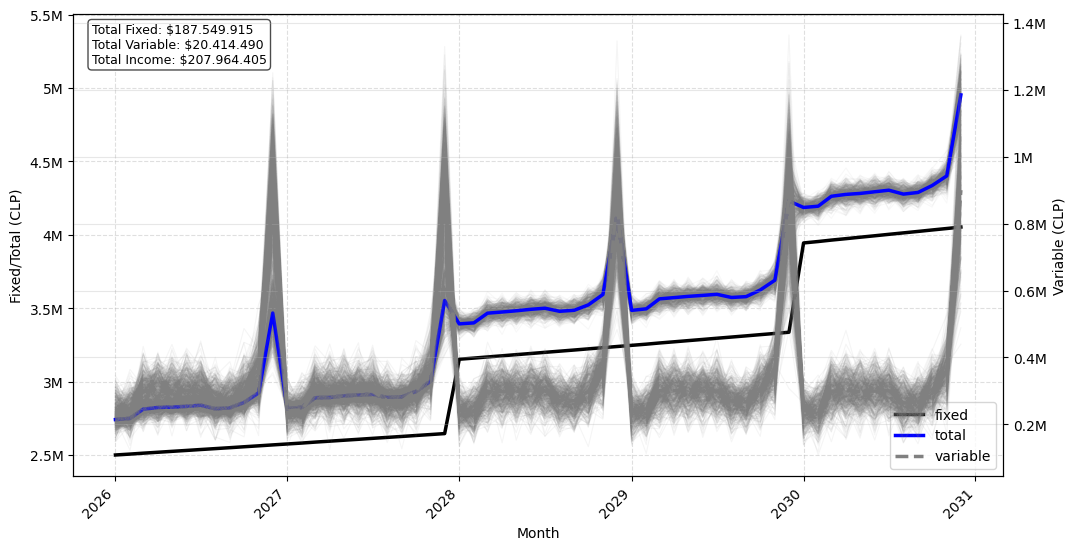

In [3]:
# Visualize Income Dynamics
# We create a temporary FinancialModel just for plotting income
# The model requires at least one account, so we create a dummy one
dummy_account = Account.from_annual("Dummy", 0.05, 0.1, initial_wealth=0)
temp_model = FinancialModel(income=income_model, accounts=[dummy_account])

temp_model.plot(
    mode="income", 
    T=60, 
    start=date(2026, 1, 1), 
    n_sims=500
)

## 3. Expense Modeling and Net Cashflow

Real-world wealth planning must account for liabilities. Expenses reduce the **disposable income** available for contribution.

### 3.1 Expense Structure
- **Fixed**: Rent/Mortgage, Basic Services
- **Variable**: Recreation, Travel, Unexpected costs

$$
A_t = \max(0, I_t^{\text{Total}} - E_t^{\text{Total}})
$$

In [6]:
# --- 1. Fixed Expenses ---
rent = FixedExpense(
    base=1_100_000,     # Monthly rent
    annual_inflation=0.03, # Increases with inflation
    name="Rent"
)

utilities = FixedExpense(
    base=200_000,
    annual_inflation=0.03,
    name="Services"
)

fixed_exp = ExpenseModel(fixed=[rent, utilities])

# Integrate expenses into IncomeModel
income_model.expenses = fixed_exp

# Check Net Disposable Income
print("Expense Integration:")
# Use output="dataframe" to access ["total"] column
gross = income_model.project(12, start=date(2026,1,1), output="dataframe")["total"].sum()
total_exp = fixed_exp.project(12, start=date(2026,1,1))["total"].sum() # project defaults to "array" (dict)
net_disposable = gross - total_exp

print(f"  Annual Gross Income: ${gross:,.0f}")
print(f"  Annual Expenses:     ${total_exp:,.0f}")
print(f"  Net Disposable:      ${net_disposable:,.0f} ({net_disposable/gross:.1%})")

Expense Integration:
  Annual Gross Income: $34,499,897
  Annual Expenses:     $15,813,355
  Net Disposable:      $18,686,542 (54.2%)


## 4. Withdrawal Rewards: "Splurges"

Unlike regular expenses (which reduce contributions), **Rewards** are lump-sum withdrawals directly from accumulated wealth. These represent major purchases (Cars, Travel, Weddings).

We model withdrawals matrix $Y \in \mathbb{R}^{T \times M}$ where $Y_{t,m}$ is the amount withdrawn from account $m$ at time $t$.

In [ ]:
# Define Rewards (One-off withdrawals)
rewards = RewardSchedule()

# 1. EuroTrip in 18 months
rewards.add(Reward(
    amount=4_000_000,
    month=18,
    name="EuroTrip 2027",
    inflation_adjusted=True
))

# 2. Car Upgrade in 36 months
rewards.add(Reward(
    amount=8_500_000,
    month=36,
    name="New Car",
    withdrawal_policy="proportional"  # Draw equally from allowed accounts
))

print("Planned Rewards:")
for r in rewards.rewards:
    print(f"  Month {r.month}: {r.name} (${r.amount:,.0f})")

## 5. Portfolio Construction

We define a diverse set of accounts with varying risk-return profiles ($(\mu, \sigma)$). Correlations are crucial for diversification.

In [ ]:
# --- Account Definitions ---
accounts = [
    Account.from_annual(
        name="Checking (Cash)",
        annual_return=0.0,
        annual_volatility=0.0,
        initial_wealth=3_000_000
    ),
    Account.from_annual(
        name="Conservative (Bonds)",
        annual_return=0.06,
        annual_volatility=0.05,
        initial_wealth=5_000_000
    ),
    Account.from_annual(
        name="Balanced (Mixed)",
        annual_return=0.10,
        annual_volatility=0.12,
        initial_wealth=2_000_000
    ),
    Account.from_annual(
        name="Aggressive (Stocks)",
        annual_return=0.14,
        annual_volatility=0.18,
        initial_wealth=1_000_000
    )
]

# Correlation Matrix (4x4)
# Cash is uncorrelated. Stocks/Bonds have correlation.
corr_matrix = np.array([
    [1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.3, 0.1],
    [0.0, 0.3, 1.0, 0.7],
    [0.0, 0.1, 0.7, 1.0]
])

# Full Financial Model
model = FinancialModel(
    income=income_model,
    accounts=accounts,
    default_correlation=corr_matrix,
    expenses=fixed_exp,
    rewards=rewards
)

print(f"Model initialized with {model.M} accounts.")

## 6. Goal-Based Optimization (The "Main Event")

We specify a **Ladder of Goals**:
1. **Emergency Fund**: Maintenance of 5M liquid (Intermediate)
2. **Wedding Fund**: 12M needed in 2 years (Intermediate)
3. **Financial Freedom**: Accumulate 150M USD (Terminal, TBD)

The optimizer will find:
1. Minimum time $T^*$ to satisfy the terminal goal.
2. Optimal contribution policy $X^*$ that satisfies all intermediate goals along the way.

### 6.1 Goal Safety Margins ($ε$)
We use strict $\epsilon$ for near-term goals and relaxed $\epsilon$ for long-term goals.

In [ ]:
goals = [
    # 1. Safety Net: Ensure > 3M in Checking/Conservative at month 12
    IntermediateGoal(
        month=12,
        account="Conservative (Bonds)",
        threshold=3_000_000,
        confidence=0.95  # Very strict (5% risk)
    ),
    
    # 2. Wedding/Project: 12M in Balanced at month 24
    IntermediateGoal(
        month=24,
        account="Balanced (Mixed)",
        threshold=8_000_000,
        confidence=0.80  # Moderate risk accepted
    ),
    
    # 3. Financial Independence (Total Wealth)
    # Note: TerminalGoal targets a specific account or sum. optimizing TOTAL wealth is implicit in objective.
    # Here we set a target for the Aggressive account as proxy for growth.
    TerminalGoal(
        account="Aggressive (Stocks)",
        threshold=80_000_000,
        confidence=0.70
    )
]

print("Optimization Goals defined.")

### 6.2 Solving the Bilevel Problem

We use **ECOS** solver via CVXPY. The outer loop searches for $T$, inner loop solves the CVaR-constrained allocation.

**Note:** This might take ~30-60 seconds depending on machine speed.

In [ ]:
optimizer = CVaROptimizer(n_accounts=model.M, objective="balanced")

print("Starting Optimization... (this performs binary search over T)")
result = model.optimize(
    goals=goals,
    optimizer=optimizer,
    T_max=120,      # Max search horizon (10 years)
    n_sims=300,     # Scenarios for optimization
    seed=42,
    verbose=True
)

print("\nOptimization Complete!")
print(result.summary())

## 7. Results Analysis & Visualization

### 7.1 Wealth Dynamics under Optimal Policy $X^*$

We verify the solution using an **out-of-sample** simulation with more scenarios ($N=1000$).
Notice how the wealth dips at month 18 and 36 due to the configured Rewards (Trip & Car).

In [ ]:
# Out-of-sample simulation
oos_sim = model.simulate_from_optimization(
    result,
    n_sims=1000,
    seed=999 # Fresh seed
)

# Plot Wealth Dynamics
model.plot(
    mode="wealth",
    result=oos_sim,
    X=result.X,
    goals=goals,
    title="Wealth Trajectories with Withdrawals & Goals"
)

### 7.2 Optimal Allocation Policy $X^*$

The heatmap below shows how the optimizer shifts contributions over time to meet specific deadlines. Often, it will prioritize safer accounts right before a deadline (gliding path).

In [ ]:
model.plot(
    mode="allocation",
    result=oos_sim,
    X=result.X,
    title="Optimal Contribution Policy Evolution"
)

### 7.3 Goal Satisfaction Verification

We rigorously check if the probability constraints hold out-of-sample. The violation rate should be $\le \epsilon$.

In [ ]:
validation = model.verify_goals(oos_sim, goals, start=date(2026, 1, 1))

print(f"{'Goal / Account':<40} | {'Req Conf':<10} | {'Actual':<10} | {'Status'}")
print("-"*80)

for goal, stats in validation.items():
    name = f"{goal.account} (M{goal.month})" if isinstance(goal, IntermediateGoal) else f"{goal.account} (Terminal)"
    req = f"{goal.confidence:.1%}"
    act = f"{1 - stats['violation_rate']:.1%}"
    status = "✅ PASS" if stats['satisfied'] else "❌ FAIL"
    
    print(f"{name:<40} | {req:<10} | {act:<10} | {status}")

## 8. Effect of "Splurges" (Rewards)

We can isolate the impact of the planned withdrawals (Trip/Car) by comparing a simulation **without** rewards against our baseline.

This helps quantify the "cost of living life" in terms of delayed financial independence.

In [ ]:
# Create counterfactual model without rewards
model_no_rewards = FinancialModel(
    income=income_model,
    accounts=accounts,
    default_correlation=corr_matrix,
    expenses=fixed_exp,
    rewards=None  # Remove rewards
)

# Simulate using the SAME policy X*
sim_no_rewards = model_no_rewards.simulate(
    T=result.T,
    n_sims=1000,
    X=result.X,
    seed=999
)

# Compare Final Total Wealth
wealth_base = oos_sim.wealth[:,-1,:].sum(axis=1)
wealth_counter = sim_no_rewards.wealth[:,-1,:].sum(axis=1)

diff = wealth_counter.mean() - wealth_base.mean()

print(f"Mean Final Wealth (With Rewards):    ${wealth_base.mean():,.0f}")
print(f"Mean Final Wealth (No Rewards):      ${wealth_counter.mean():,.0f}")
print(f"Cost of Rewards (Future Value):      ${diff:,.0f}")

plt.figure(figsize=(10, 6))
plt.hist(wealth_base/1e6, bins=50, alpha=0.6, label='With Rewards (Trip+Car)')
plt.hist(wealth_counter/1e6, bins=50, alpha=0.6, label='No Rewards (Frugal)')
plt.xlabel('Final Wealth ($ millions)')
plt.ylabel('Frequency')
plt.title('Impact of Withdrawals on Terminal Wealth Distribution')
plt.legend()
plt.show()